In [3]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 设置中文字体和负号正常显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取CSV文件  
df = pd.read_csv("./Lingcang202001-202312.csv")

# 将year, month, day合并为日期，并转换为datetime类型  
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# 删除原始的year, month, day列  
df.drop(['year', 'month', 'day'], axis=1, inplace=True)

# 按照日期排序，确保数据的连续性  
df.sort_values('date', inplace=True)

# 设置日期为索引  
df.set_index('date', inplace=True)

# 划分训练集和验证集  
# 训练集：2020年1月1日至2022年11月30日  
# 验证集：2022年12月1日至2022年12月31日  
train_end_date = "2022-11-30"
validation_start_date = "2022-12-01"
validation_end_date = "2022-12-31"
test_start_date = "2023-01-01"

train_df = df.loc[df.index <= train_end_date]
validation_df = df.loc[(df.index >= validation_start_date) & (df.index <= validation_end_date)]
test_df = df.loc[df.index >= test_start_date]

# 打印训练集和验证集的大小  
print(f"训练集大小: {len(train_df)}")
print(f"验证集大小: {len(validation_df)}")
print(f"测试集大小: {len(test_df)}")

# 如果需要重置索引，可以使用以下代码（可选）  
# train_df.reset_index(inplace=True, drop=True)  
# validation_df.reset_index(inplace=True, drop=True)

训练集大小: 1070
验证集大小: 31
测试集大小: 363


Epoch 1/50
1063/1063 [==============================] - 17s 15ms/step - loss: 0.0134
Epoch 2/50
1063/1063 [==============================] - 17s 16ms/step - loss: 0.0076
Epoch 3/50
1063/1063 [==============================] - 17s 16ms/step - loss: 0.0074
Epoch 4/50
1063/1063 [==============================] - 16s 15ms/step - loss: 0.0069
Epoch 5/50
1063/1063 [==============================] - 17s 16ms/step - loss: 0.0069
Epoch 6/50
1063/1063 [==============================] - 17s 16ms/step - loss: 0.0066
Epoch 7/50
1063/1063 [==============================] - 17s 16ms/step - loss: 0.0065
Epoch 8/50
1063/1063 [==============================] - 17s 16ms/step - loss: 0.0066
Epoch 9/50
1063/1063 [==============================] - 17s 16ms/step - loss: 0.0066
Epoch 10/50
1063/1063 [==============================] - 16s 15ms/step - loss: 0.0065
Epoch 11/50
1063/1063 [==============================] - 16s 15ms/step - loss: 0.0065
Epoch 12/50
1063/1063 [==============================] - 16s 15

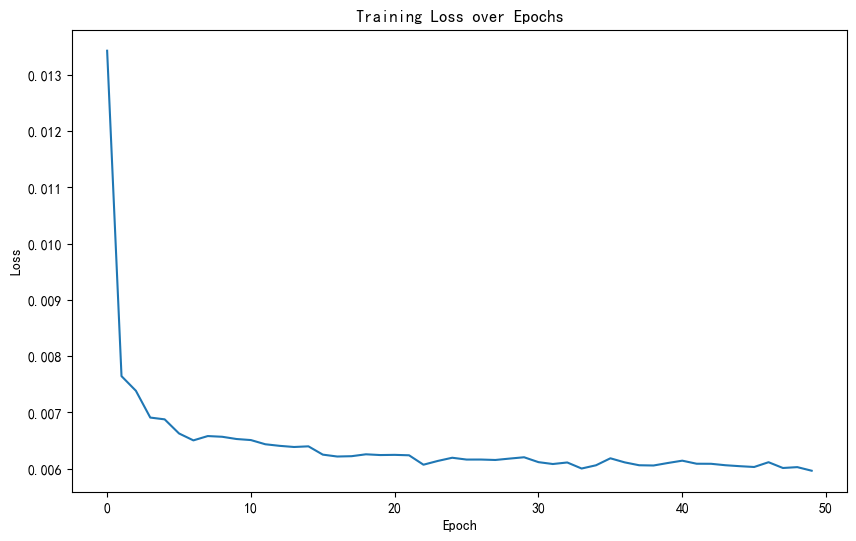

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Scaler saved to ./lstm_scaler.joblib
模型已保存为LSTM_temperature_prediction_model.h5


In [4]:
import joblib

# 数据预处理  
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_df['average'].values.reshape(-1, 1))
scaled_validation_data = scaler.transform(validation_df['average'].values.reshape(-1, 1))
scaled_test_data = scaler.transform(test_df['average'].values.reshape(-1, 1))

# 创建时序数据生成器  
n_input = 7  # 使用前n_input个时间步预测下一个时间步  
n_features = 1  # 特征数量，这里是平均气温  
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

# 构建LSTM模型  
model = Sequential()  # 创建Sequential模型
model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))  # 添加LSTM层
model.add(Dense(1))  # 添加全连接层
model.compile(optimizer='adam', loss='mse')  # 编译模型

# 训练模型  
history = model.fit(generator, epochs=50, verbose=1, batch_size=16)  # 50个epoch, verbose=1表示输出训练过程

# 验证模型  
validation_x = []  # 用于存放验证集的输入数据
validation_y = []  # 用于存放验证集的标签数据
for i in range(n_input, len(scaled_validation_data)):  # 从第n_input个数据开始
    validation_x.append(scaled_validation_data[i - n_input:i])  # 用前n_input个数据作为输入
    validation_y.append(scaled_validation_data[i])  # 第n_input个数据作为标签
validation_x = np.array(validation_x)  # 转换为NumPy数组
validation_y = np.array(validation_y)  # 转换为NumPy数组

validation_loss = model.evaluate(validation_x, validation_y, verbose=0)  # 计算验证集的损失
print(f'Validation Loss: {validation_loss}')

# 可视化模型的训练过程
losses = history.history['loss'] # 从History对象中提取损失值  
# 使用matplotlib绘制损失曲线  
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
# 如果需要，可以将预测结果反归一化回原始的温度范围  
# predicted_temperatures = scaler.inverse_transform(model.predict(validation_x))

# 输出模型的摘要信息
model.summary()

# 保存scaler  
scaler_path = './lstm_scaler.joblib'  # 定义scaler保存的文件路径  
joblib.dump(scaler, scaler_path)  # 使用joblib保存scaler对象  
print(f"Scaler saved to {scaler_path}")

# 保存模型
model.save('LSTM_temperature_prediction_model.h5')
print('模型已保存为LSTM_temperature_prediction_model.h5')

In [5]:
# 假设model是之前训练好的LSTM模型，scaler是之前用于数据归一化的MinMaxScaler对象  

# 使用模型对验证集进行预测  
validation_x = []
for i in range(n_input, len(scaled_validation_data)):
    validation_x.append(scaled_validation_data[i - n_input:i])
validation_x = np.array(validation_x)

# 预测验证集  
predictions_scaled = model.predict(validation_x)

# 将预测结果反归一化回原始温度范围  
predictions = scaler.inverse_transform(predictions_scaled)

# 将预测结果输出到控制台或保存到文件中  
for i, pred in enumerate(predictions):
    print(f"Predicted temperature for validation point {i + 1}: {pred[0]:.2f} ℃") 


1/1 [==============================] - 0s 132ms/step
Predicted temperature for validation point 1: 13.78 ℃
Predicted temperature for validation point 2: 13.80 ℃
Predicted temperature for validation point 3: 13.22 ℃
Predicted temperature for validation point 4: 12.59 ℃
Predicted temperature for validation point 5: 12.59 ℃
Predicted temperature for validation point 6: 13.04 ℃
Predicted temperature for validation point 7: 13.38 ℃
Predicted temperature for validation point 8: 13.00 ℃
Predicted temperature for validation point 9: 12.34 ℃
Predicted temperature for validation point 10: 13.34 ℃
Predicted temperature for validation point 11: 11.03 ℃
Predicted temperature for validation point 12: 10.92 ℃
Predicted temperature for validation point 13: 11.24 ℃
Predicted temperature for validation point 14: 11.37 ℃
Predicted temperature for validation point 15: 12.04 ℃
Predicted temperature for validation point 16: 12.10 ℃
Predicted temperature for validation point 17: 12.35 ℃
Predicted temperature

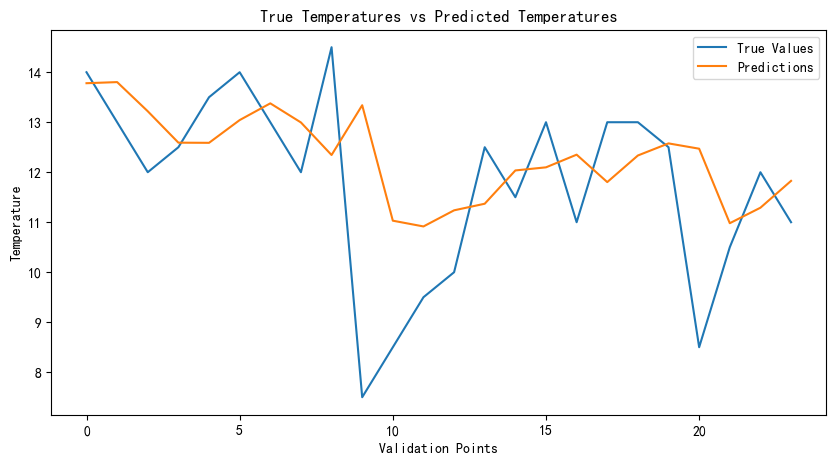

In [6]:
# 如果validation_y未反归一化，请取消注释以下行并进行反归一化  
validation_y = scaler.inverse_transform(validation_y.reshape(-1, 1)).flatten()

# 绘制真实值和预测值的对比图  
plt.figure(figsize=(10, 5))
plt.plot(validation_y, label='True Values')
plt.plot(predictions.flatten(), label='Predictions')
plt.title('True Temperatures vs Predicted Temperatures')
plt.xlabel('Validation Points')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 假设validation_y是验证集的真实值（且已经归一化）  
# 如果validation_y未归一化，需要先使用scaler进行归一化  
# validation_y = scaler.transform(validation_y_original.reshape(-1, 1))  

# 计算MSE  
mse = mean_squared_error(validation_y, predictions_scaled)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# 计算RMSE  
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 计算MAE  
mae = mean_absolute_error(validation_y, predictions_scaled)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# 计算MAPE
mape = np.mean(np.abs((validation_y - predictions_scaled) / validation_y)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# 计算R2
from sklearn.metrics import r2_score
r2 = r2_score(validation_y, predictions_scaled)
print(f"R2 Score: {r2:.4f}")

Mean Squared Error (MSE): 137.1579
Root Mean Squared Error (RMSE): 11.7114
Mean Absolute Error (MAE): 11.5703
Mean Absolute Percentage Error (MAPE): 98.25%
R2 Score: -39.8971


12/12 [==============================] - 0s 4ms/step


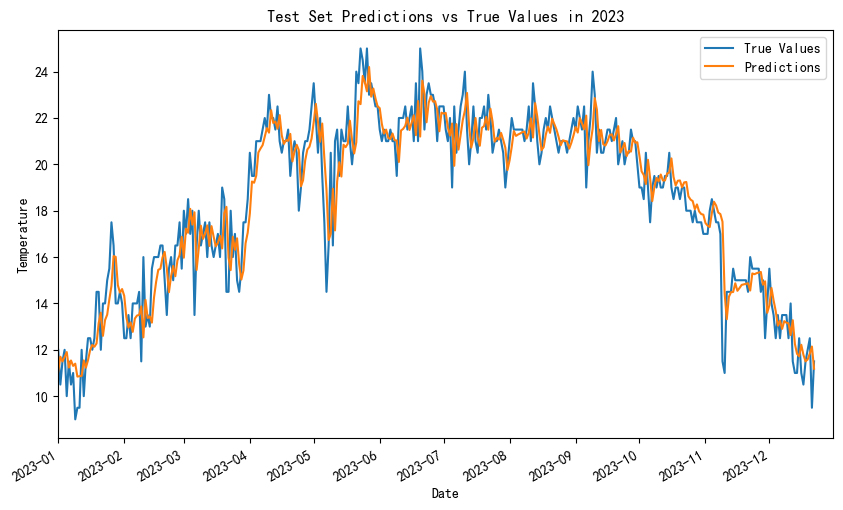

In [8]:
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# 加载已保存的模型  
from keras.models import load_model
model = load_model('LSTM_temperature_prediction_model.h5')

# 准备测试集数据  
test_x = []  # 用于存放测试集的输入数据  
test_y = []  # 存放测试集的真实标签数据（如果有的话，可用于对比）  

for i in range(n_input, len(scaled_test_data)):  # 从第n_input个数据开始  
    test_x.append(scaled_test_data[i - n_input:i])  # 用前n_input个数据作为输入  
    test_y.append(scaled_test_data[i])  # 保存真实值用于对比（如果需要）  

test_x = np.array(test_x)  # 转换为NumPy数组  
test_y = np.array(test_y)  # 转换为NumPy数组（如果需要对比真实值）  

# 创建一个从2023-01-01开始的日期序列，长度为test_y的长度  
start_date = datetime(2023, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(len(test_y))]

# 使用模型对测试集进行预测  
predictions_scaled = model.predict(test_x)

# 如果需要，将预测结果和测试集真实值反归一化回原始的温度范围  
predictions = scaler.inverse_transform(predictions_scaled)  # 反归一化预测值  
test_y_original = scaler.inverse_transform(test_y.reshape(-1, 1)).flatten()  # 反归一化真实值  

# 绘制测试集真实值与预测值的对比图  
plt.figure(figsize=(10, 6))

# 使用dates作为x轴的值  
plt.plot(dates, test_y_original, label='True Values')  # 绘制真实值  
plt.plot(dates, predictions, label='Predictions')  # 绘制预测值  

# 设置x轴为日期格式  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # 每个月显示一个刻度  
plt.gcf().autofmt_xdate()  # 自动旋转日期标记  

plt.xlim(datetime(2023, 1, 1), datetime(2023, 12, 31))  # 设置x轴范围
plt.title('Test Set Predictions vs True Values in 2023')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


In [9]:
# 测试集模型评估
# 计算MSE
mse = mean_squared_error(test_y_original, predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# 计算RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 计算MAE
mae = mean_absolute_error(test_y_original, predictions)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# 计算MAPE
mape = np.mean(np.abs((test_y_original - predictions) / test_y_original)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# 计算R2
r2 = r2_score(test_y_original, predictions)
print(f"R2 Score: {r2:.4f}")

Mean Squared Error (MSE): 1.5858
Root Mean Squared Error (RMSE): 1.2593
Mean Absolute Error (MAE): 0.9363
Mean Absolute Percentage Error (MAPE): 24.87%
R2 Score: 0.8875


In [10]:
# 假设 target_date 是你想要预测的日期  
target_date = datetime(2023, 5, 20)
n_input = 7  # 假设模型是基于过去7天的数据来预测下一天  

# previous_data 应该包含 target_date 之前 n_input 天的数据，且已经归一化  
# 这里只是一个示例，你需要用实际的数据替换它  
previous_data = np.random.rand(n_input)  # 假设数据，需要替换为真实数据  

# 将数据构造成模型所需的输入格式  
input_data = previous_data.reshape(1, n_input, 1)  # 假设模型输入形状为 (batch_size, time_steps, features)  

# 使用模型进行预测  
predictions_scaled = model.predict(input_data)

# 反归一化预测结果  
predictions = scaler.inverse_transform(predictions_scaled)

print(f"Predicted temperature for {target_date}: {predictions[0][0]:.2f} ℃")

1/1 [==============================] - 0s 21ms/step
Predicted temperature for 2023-05-20 00:00:00: 17.70 ℃
